**Experiment**: Detecting distribution shift with uncertainty

**Dataset**: https://www.kaggle.com/c/ieee-fraud-detection

**Uncertainty estimation**: Aggregating random forest by the standard deviation

**Methodology**: For 10 rounds add values to one feature (for one group) and evaluate the uncertainty of this group. 



In [67]:
import pandas as pd
from ensemble import StdForestClassifier
from category_encoders.m_estimate import MEstimateEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,classification_report
from sklearn.ensemble import RandomForestClassifier
import shap
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
plt.style.use('seaborn-whitegrid')

In [2]:
def modify_group(
    data, std=1, feat="ProductCD", feat_modify="TransactionAmt", category="C"
):
    d = pd.DataFrame()

    for cat in data[feat].unique():
        aux = data[data[feat] == cat].copy()
        if cat == category:
            deviation = np.std(aux[feat_modify])
            aux[feat_modify] = aux[feat_modify] + std * deviation

        d = d.append(aux)
    return d

In [3]:
def pipe_predict_std(pipeline,data):
    data = pipeline[:-1].transform(data)
    return pipeline.named_steps['rf'].predict_std(data)

In [4]:
df = pd.read_csv('data/train_transaction.csv')

In [5]:
df = df.iloc[:, :-300]
undersample = RandomUnderSampler(sampling_strategy=0.5)

In [6]:
X = df.drop(columns=['TransactionID', 'isFraud', 'TransactionDT'])
y = df[['isFraud']]

In [7]:
X,y = undersample.fit_resample(X,y)

In [8]:
X = X.fillna(-1)

In [9]:
X_tr, X_te, y_tr, y_te = train_test_split(X,y,stratify=y,test_size=0.1)

In [10]:
rf = StdForestClassifier()
enc = MEstimateEncoder()
pipe = Pipeline([("enc", enc), ("rf", rf)])

In [11]:
%%time
pipe.fit(X_tr,y_tr)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 10.2 s, sys: 202 ms, total: 10.4 s
Wall time: 10.5 s


Pipeline(steps=[('enc',
                 MEstimateEncoder(cols=['ProductCD', 'card4', 'card6',
                                        'P_emaildomain', 'R_emaildomain', 'M1',
                                        'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
                                        'M8', 'M9'])),
                ('rf',
                 <ensemble.StdForestClassifier object at 0x7fbb8cbdab50>)])

In [12]:
print(classification_report(pipe.predict(X_te),y_te))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      4407
           1       0.78      0.90      0.84      1792

    accuracy                           0.90      6199
   macro avg       0.87      0.90      0.88      6199
weighted avg       0.91      0.90      0.90      6199



In [53]:
res = {}
for i in range(0,10):
    aux = modify_group(X_te,std=i)


    aux['preds'] = pipe_predict_std(pipe,aux)

    res[i] = aux.groupby('ProductCD').preds.mean()

In [58]:
res = pd.DataFrame(res).T

In [62]:
res

ProductCD,C,H,R,S,W
0,0.284803,0.285773,0.265077,0.269011,0.308994
1,0.297459,0.285773,0.265077,0.269011,0.308994
2,0.306495,0.285773,0.265077,0.269011,0.308994
3,0.314067,0.285773,0.265077,0.269011,0.308994
4,0.318485,0.285773,0.265077,0.269011,0.308994
5,0.320378,0.285773,0.265077,0.269011,0.308994
6,0.322979,0.285773,0.265077,0.269011,0.308994
7,0.324105,0.285773,0.265077,0.269011,0.308994
8,0.325867,0.285773,0.265077,0.269011,0.308994
9,0.326436,0.285773,0.265077,0.269011,0.308994


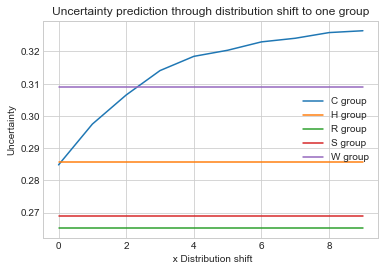

In [71]:
plt.figure()
plt.title('Uncertainty prediction through distribution shift to one group')
plt.ylabel('Uncertainty')
plt.xlabel(' x Distribution shift')
plt.plot(res['C'],label='C group')
plt.plot(res['H'],label='H group')
plt.plot(res['R'],label='R group')
plt.plot(res['S'],label='S group')
plt.plot(res['W'],label='W group')
plt.legend()
plt.show()
